<h1 style="color:rgb(0,120,170)">Assignment 3: PCA</h1>

This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h2 style="color:rgb(0,120,170)">Task 1: Implementation of PCA for a standard data set from scratch: </h2>

The goal of this task is to implement the PCA algorithm as introduced in the slides by hand. PCA analysis is a powerful tool to identify patterns in data; it is used to find correlations between variables, to determine the directions of maximum variance and project it onto a smaller dimensional subspace that maintains most of the information. To fix the overall notation, we will denote by $n$ the number of samples, by $d$ the number of different features, and $k<d$ the dimension of the space, on which we want to project. We will work with the famous iris dataset which contains measurements for $n=150$ iris flowers from three different classes, namely:

* Iris-setosa ($n_{\textrm{se}}=50$)
* Iris-versicolor ($n_{\textrm{ve}}=50$)
* Iris-virginica ($n_{\textrm{vi}}=50$).

Moreover, we have the following $d=4$ features:

* sepal length in cm
* sepal width in cm
* petal length in cm
* petal width in cm

<img src = "iris_with_labels.jpg">

For more information on the dataset go to https://archive.ics.uci.edu/ml/datasets/Iris.

In the next step we want to read in the data set using the pandas package.

In [9]:
%pip install seaborn

%pip install scikit-learn





[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 18.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 15.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports and reading data set. Nothing to do here.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(
    filepath_or_buffer='/Users/korhanerdogdu/Desktop/unsupervised_ml/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

In [3]:
# Split data table into data X and class labels y. Nothing to do here.
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values

In [4]:
df

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Our iris dataset is now an $n \times d=150 \times 4$ matrix $\mathbf{X}$, where the columns are the different features, and every row is an individual flower sample. Each sample row $\mathbf{x}_i$ for $1\le i \le n=150$ is as a $4$-dimensional vector.

<h3 style="color:rgb(210,90,80)">Exercise 1 (10 points):</h3>

* To get a feeling for how the 3 different flower classes are distributed along the 4 different features, visualize them via histograms.

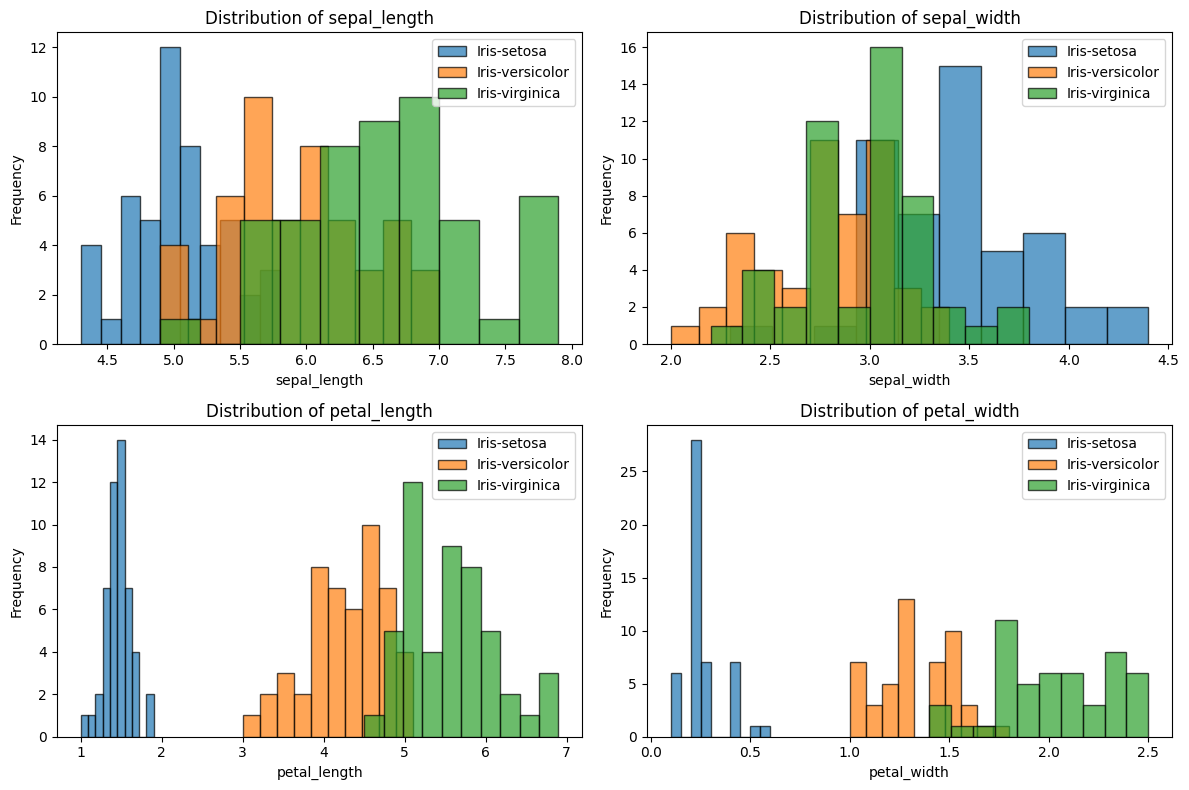

In [5]:
########## YOUR SOLUTION HERE ##########  

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and is already defined

# Define the features and class names
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
class_names = df['class'].unique()

# Create a figure and axis for each feature
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

for i, feature in enumerate(features):
    for class_name in class_names:
        # Select the subset of the data that corresponds to the current class
        subset = df[df['class'] == class_name]
        # Plot the histogram of the current feature for this subset
        axs[i].hist(subset[feature], alpha=0.7, label=class_name, bins=10, edgecolor='black')
    
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


As PCA leads to a (sub)space that maximizes the variance along the axes, it makes sense to standardize the data, especially, if they were measured on different scales. We thus transform the data onto unit scale (mean=0 and variance=1), which is needed in many machine learning algorithms.

In [10]:
#nothing to do here
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

Next, we compute the covariance matrix $\mathbf{C}$, which is a $d×d$ matrix (real and symmetric), where each element represents the covariance between two features. $\mathbf{C}$ can therefore be calculated as follows:
$$
c_{jk}=\frac{1}{n-1} \sum_{i=1}^{n} (x_i^{(j)}-\overline{x}^{(j)})(x_i^{(k)}-\overline{x}^{(k)}),
$$
where $\overline{x}^{(j)}$ denotes the mean of the $j$-th feature. In matrix notation, this can be expressed as follows:
$$
\mathbf{C}=\frac{1}{n-1}(\mathbf{X}-\overline{\mathbf{x}})^T (\mathbf{X}-\overline{\mathbf{x}}),
$$
with $\overline{\mathbf{x}}= \frac1n \sum_{i=1}^{n} \mathbf{x}_i$ denoting the mean vector. The eigenvectors and eigenvalues of $\mathbf{C}$ represent the most important part of PCA: The eigenvectors (principal components, German: "Hauptachsen") determine the directions of the new feature space, and the eigenvalues contain information about their importance. Put differently, the eigenvalues explain the variance of the data along the new feature axes. Computing $\mathbf{C}$ and its eigendecomposition should therefore be achieved in the following tasks: 

----

***Vector Operations***

$$
\mathbf{C}=\frac{1}{n-1}(\mathbf{X}-\overline{\mathbf{x}})^T (\mathbf{X}-\overline{\mathbf{x}}),
$$





- **$\mathbf{X}$**: This is the data matrix where each row represents an observation (or a data point) and each column represents a feature. So, if you have a dataset with $n$ observations and $m$ features, $\mathbf{X}$ would be an $n \times m$ matrix.



- **$\overline{\mathbf{x}}$**: This represents the mean vector of the dataset. It is computed by taking the mean of each feature (column) in $\mathbf{X}$, resulting in a vector of length $m$ (where $m$ is the number of features). The mean vector is then subtracted from each row in $\mathbf{X}$ to center the data around the origin (0). This centering step is crucial because it ensures that the covariance calculation measures the variability of the features relative to their means.



- **$(\mathbf{X} - \overline{\mathbf{x}})$**: This operation centers the data by subtracting the mean vector $\overline{\mathbf{x}}$ from every observation in $\mathbf{X}$. If $\mathbf{X}$ is already centered or standardized, $\overline{\mathbf{x}}$ would be a vector of zeros, and this step would not change $\mathbf{X}$.



- **$(\mathbf{X} - \overline{\mathbf{x}})^T$**: This operation transposes the centered data matrix. Transposing flips the matrix so that rows become columns and vice versa, turning the $n \times m$ centered matrix into an $m \times n$ matrix. This step is necessary for matrix multiplication to align the dimensions properly for the covariance calculation.



- **$\frac{1}{n-1}$**: The normalization by $n-1$ (where $n$ is the number of observations) instead of $n$ uses Bessel's correction, which corrects the bias in the estimation of the population variance from a sample. This is standard practice in statistics to make the covariance matrix an unbiased estimator of the true population covariance.



- **$(\mathbf{X} - \overline{\mathbf{x}})^T (\mathbf{X} - \overline{\mathbf{x}})$**: This matrix multiplication operation computes the covariance matrix. The result is an $m \times m$ matrix where each element $c_{jk}$ represents the covariance between features $j$ and $k$. ***The diagonal elements of this matrix represent the variance of each feature.***



- **$\mathbf{C}$**: The final result, an $m \times m$ covariance matrix that describes the covariance between every pair of features in the dataset. Diagonal entries are variances of individual features, and off-diagonal entries are covariances between pairs of features.



In summary, this formula and its corresponding code calculate the covariance matrix for a dataset, which is a fundamental step in many statistical analyses and machine learning algorithms, including Principal Component Analysis (PCA).


----


<h3 style="color:rgb(210,90,80)">Exercise 2 (5 points):</h3>


* Using the previous formulas and explanations, implement the covariance matrix for the iris data set and print the result. Don't use the np.cov function. Verify first that all the feature means are zero due to the standardization we did above.

In [11]:
########## YOUR SOLUTION HERE ##########   

# Calculating covariance matrix without np.cov.
def calculate_covariance_matrix(X):
    n_samples = np.shape(X)[0]
    covariance_matrix = (X.T @ X) / (n_samples - 1)
    return covariance_matrix

cov_matrix = calculate_covariance_matrix(X_std)

print("\nCovariance matrix:\n", cov_matrix)



Covariance matrix:
 [[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


***X***: The input matrix where rows represent samples and columns represent features. For example, in the context of the Iris dataset, each row could represent a flower, and each column could represent measurements like sepal length, sepal width, etc.


***n_samples = np.shape(X)[0]:*** This line calculates the number of samples (or observations) in the dataset. np.shape(X)[0] returns the size of the first dimension of 
X, which corresponds to the number of rows (samples).


***covariance_matrix = (X.T @ X) / (n_samples - 1):*** This line computes the covariance matrix. 

***X.T:***  Transposes the matrix 
X, flipping rows and columns. If 
X is of shape 
(n,m), where 
n is the number of samples and 
m is the number of features, then X.T will be of shape 
(m,n).


***@:*** Represents matrix multiplication in Python (using NumPy). So, X.T @ X performs matrix multiplication between the transpose of X and X itself. This operation is a key step in computing the covariance matrix, summing up the product of differences from the mean for each feature combination across all samples.



***/ (n_samples - 1):*** Divides the sum of the product of differences by 
n−1 (where 
n is the number of samples) to normalize the covariance values. This is done to account for the degrees of freedom in the dataset. Using 
n−1 instead of 
n corrects the bias in the estimation of the population covariance from a sample.


***return covariance_matrix:*** Returns the computed covariance matrix. This matrix is symmetric and has dimensions 
(m,m), where 
m is the number of features. Each element 
c 
ij
in the matrix represents the covariance between the 
i-th and 
j-th features. The diagonal elements of the matrix (where 
i=j) represent the variances of the features.

<h3 style="color:rgb(210,90,80)">Exercise 3 (5 points):</h3>

* Next, perform an eigendecomposition on the covariance matrix  and print the eigenvectors and eigenvalues. You can use whatever method you like.

In [12]:
########## YOUR SOLUTION HERE ########## 

import numpy as np

def perform_eigendecomposition(cov_matrix):
    """
    Perform eigendecomposition on a given covariance matrix.

    Parameters:
    - cov_matrix: A square covariance matrix.

    Returns:
    - eigenvalues: An array of eigenvalues.
    - eigenvectors: A matrix where each column is an eigenvector corresponding to the eigenvalues.
    """
    # Perform the eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) 
    
    """
    
    linalg: This is a submodule within NumPy that stands for "linear algebra."
    numpy.linalg includes a set of functions for solving linear algebra problems, including matrix factorizations, solving linear systems, computing determinants, and more. 

    eig: This specific function within the numpy.linalg submodule is used to compute the eigenvalues (λ) and right eigenvectors (v) of a given square matrix (A). It solves the equatio
    Av=λv, where A is a square matrix, λ represents the eigenvalues of A, and  v represents the eigenvectors of A.
    
    """
    
    return eigenvalues, eigenvectors


# Perform eigendecomposition
eigenvalues, eigenvectors = perform_eigendecomposition(cov_matrix)

# Print the results
print("Eigenvalues:\n", eigenvalues)
print("\nEigenvectors:\n", eigenvectors)


Eigenvalues:
 [2.93035378 0.92740362 0.14834223 0.02074601]

Eigenvectors:
 [[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]


To decide which eigenvector(s) can safely be dropped, we take a more careful look at the corresponding eigenvalues: In order to do so, we rank the eigenvalues from highest to lowest and choose the top $k$ eigenvectors. The eigenvectors with the lowest eigenvalues contain the least information about the distribution of the data; these are the ones we will get rid of.

<h3 style="color:rgb(210,90,80)">Exercise 4 (10 points):</h3>

* Make a list of (eigenvalue, eigenvector) tuples, sort the (eigenvalue, eigenvector) tuples from high to low (with respect to the eigenvalues) and print the tuples in decreasing order to confirm, that the list is correctly sorted. Also check that the eigenvectors are all normalized and all orthogonal to each other.

In [13]:
########## YOUR SOLUTION HERE ##########   

def analyze_eigensystem(cov_matrix):  # tuples are not mutable
    """
    Perform eigendecomposition on a given covariance matrix, sort the (eigenvalue, eigenvector) tuples,
    check if eigenvectors are normalized and orthogonal to each other, and print the results.
    
    Parameters:
    - cov_matrix: A square covariance matrix.
    
    """
    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Make a list of (eigenvalue, eigenvector) tuples and sort them
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(len(eigenvalues))] # list of tuples
    eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)
    
    """
eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(len(eigenvalues))]
    
This line creates a list of tuples, eigen_pairs, where each tuple contains an eigenvalue and its corresponding eigenvector from the eigendecomposition.

np.abs(eigenvalues[i]) takes the absolute value of the i-th eigenvalue.
This is useful because eigenvalues can be complex numbers in general, and their magnitude can be interpreted as the "strength" or "importance" of the corresponding eigenvector in certain contexts (e.g., Principal Component Analysis).
However, for covariance matrices, eigenvalues are real and non-negative.

eigenvectors[:, i] selects the i-th column from the eigenvectors array, which corresponds to the i-th eigenvector.

The comprehension iterates over each index i that corresponds to an eigenvalue (and its associated eigenvector), creating a list of these pairs.
    
    
    
    An example of an eigenvalue-eigenvector tuple from the sorted list is:
    (3.0, array([0.70710678, 0.70710678]))

    
    """
    

    # Print sorted tuples
    print("Sorted (eigenvalue, eigenvector) tuples:")
    for pair in eigen_pairs:
        print(f"Eigenvalue: {pair[0]}, Eigenvector: {pair[1]}")

    # Check if eigenvectors are normalized
    print("\nChecking if eigenvectors are normalized:")
    for _, vec in eigen_pairs:
        print(f"Norm of eigenvector: {np.linalg.norm(vec)}")
        
    """
    
    For an eigenvector to be considered normalized, the sum of the squares of its components must equal 1.
    This is a common condition in many mathematical and engineering applications because normalized vectors are often easier to work with, especially in contexts involving directions rather than magnitudes, like in Principal Component Analysis (PCA) or when solving systems of linear equations.
    
    """

    # Check orthogonality of eigenvectors
    print("\nChecking orthogonality of eigenvectors:")  # comparing all the vectors with eachother
    for i in range(len(eigen_pairs)):
        for j in range(i+1, len(eigen_pairs)):
            orthogonality = np.dot(eigen_pairs[i][1], eigen_pairs[j][1])
            print(f"Dot product (orthogonality) between eigenvector {i} and {j}: {orthogonality}")
            

            
    """
    Orthogonality, in the context of vectors, means that two vectors are perpendicular to each other.
    Mathematically, two vectors a and b are orthogonal if their dot product equals zero: a⋅b=0
    """

# Analyze the eigensystem of the sample covariance matrix
analyze_eigensystem(cov_matrix)



Sorted (eigenvalue, eigenvector) tuples:
Eigenvalue: 2.930353775589315, Eigenvector: [ 0.52237162 -0.26335492  0.58125401  0.56561105]
Eigenvalue: 0.9274036215173418, Eigenvector: [-0.37231836 -0.92555649 -0.02109478 -0.06541577]
Eigenvalue: 0.14834222648164005, Eigenvector: [-0.72101681  0.24203288  0.14089226  0.6338014 ]
Eigenvalue: 0.02074601399559629, Eigenvector: [ 0.26199559 -0.12413481 -0.80115427  0.52354627]

Checking if eigenvectors are normalized:
Norm of eigenvector: 0.9999999999999999
Norm of eigenvector: 0.9999999999999999
Norm of eigenvector: 1.0
Norm of eigenvector: 0.9999999999999999

Checking orthogonality of eigenvectors:
Dot product (orthogonality) between eigenvector 0 and 1: 2.2752141386267945e-16
Dot product (orthogonality) between eigenvector 0 and 2: 1.9128128145728628e-16
Dot product (orthogonality) between eigenvector 0 and 3: 3.804652298983212e-18
Dot product (orthogonality) between eigenvector 1 and 2: 1.0332322213763956e-16
Dot product (orthogonality) bet

After sorting the eigenpairs, we ask ourselves, how many principal components we want to have. A useful measure is the so-called "explained variance", which can be calculated from the eigenvalues by computing the ratios $\frac{\lambda_j}{\sum_{k=1}^d \lambda_k}$, where $\lambda_j$ denotes the $j$-th (sorted) eigenvalue of $\mathbf{C}$ and $1\le j \le d$. The explained variance tells us how much information is contained in each of the principal components. 

<h3 style="color:rgb(210,90,80)">Exercise 5 (10 points):</h3>

* Write a code that computes the explained variance for each eigenvalue of the iris-dataset example and print the result.

In [14]:
########## YOUR SOLUTION HERE ##########  

# Total variance is the sum of all eigenvalues
total_variance = sum(eigenvalues)

# Calculating explained variance for each eigenvalue
explained_variances = [(i / total_variance) * 100 for i in eigenvalues]

# Printing the explained variance for each component
for i, variance in enumerate(explained_variances, 1):
    print(f"Component {i}: {variance:.2f}%")
    


Component 1: 72.77%
Component 2: 23.03%
Component 3: 3.68%
Component 4: 0.52%


The previous task clearly shows that most of the variance can be explained by the first principal component alone. The second principal component still contains some information, while the third and fourth principal components can safely be neglected. 

Next, we come to the construction of the $d \times k$ transformation (and projection) matrix $\mathbf{W}$ that will be used to transform the Iris data onto the new (and smaller) feature subspace. It basically just consists of the first $k$ eigenvectors. In our Iris dataset example, we choose to reduce the $4$-dimensional feature space to a $k=2$ dimensional one.

In the final, step we will use $\mathbf{W}$ to transform our samples onto the new subspace via the equation
$\mathbf{Y}=\mathbf{X}\,\mathbf{W}$, where $\mathbf{Y}$ is now an $n \times k$ matrix (i.e. $150 \times 2$ in our case).

<h3 style="color:rgb(210,90,80)">Exercise 6 (10 points):</h3>

* Write a code that computes the transformation matrix $\mathbf{W}$ and the new representation matrix $\mathbf{Y}$ for the Iris data set and print the results.

***Transformation Matrix (W):*** This matrix is constructed from the eigenvectors of the covariance matrix of 
X, specifically those corresponding to the largest eigenvalues. These eigenvectors represent the principal components, or the directions in the dataset where variance is maximized. The Transformation Matrix effectively serves as a set of new axes along which the data will be projected.

***Representation Matrix (Y):*** After the transformation, the dataset X is projected onto the new axes defined by W, resulting in the Representation Matrix Y. Mathematically, this is represented as: Y=XW
Here, Y is the dataset in the new space formed by the principal components. Each column in 
Y corresponds to a principal component, and each row represents the original data observations transformed into this new space.


***IMPORTANT:*** When we drop some eigenvalues the new matrix becomes transformation matrix. When we move the transition matrix on the new axis (for instance PC1 should be horizental and PC2 should be perpendiclar to PC1 at the end of the operations), it becomes representation matrix.


In [15]:
########## YOUR SOLUTION HERE ##########   

# Construct the transformation matrix W using the top 2 eigenvectors
# Here we're simulating selecting the first 2 eigenvectors
W = eigenvectors[:, :2] # first 2 eigenvectors, (it is a new matrix when we drop the other features).

# Compute the new representation matrix Y
Y = X_std.dot(W)

# Printing the transformation matrix W and the first few rows of the new representation Y for inspection
print("Transformation Matrix W:\n", W)
print("\nNew Representation Matrix Y (first 5 rows):\n", Y[:5, :])


Transformation Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]

New Representation Matrix Y (first 5 rows):
 [[-2.26454173 -0.5057039 ]
 [-2.0864255   0.65540473]
 [-2.36795045  0.31847731]
 [-2.30419716  0.57536771]
 [-2.38877749 -0.6747674 ]]


In [16]:
eigenvectors    # there are 4 vectors (upside-down)

array([[ 0.52237162, -0.37231836, -0.72101681,  0.26199559],
       [-0.26335492, -0.92555649,  0.24203288, -0.12413481],
       [ 0.58125401, -0.02109478,  0.14089226, -0.80115427],
       [ 0.56561105, -0.06541577,  0.6338014 ,  0.52354627]])

All the steps that we did so far can be also done with the following implemented algorithm from the sklearn package. The previously computed matrix $\mathbf{Y}$ should match $\mathbf{Y}_\textrm{sklearn}$ from the following code. Note that signs (of individual components) might differ. This is because the directions of the eigenvectors are not fixed and different methods may make different choices.

In [17]:
#nothing to do here
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)
print(Y_sklearn)

[[-2.26454173e+00  5.05703903e-01]
 [-2.08642550e+00 -6.55404729e-01]
 [-2.36795045e+00 -3.18477311e-01]
 [-2.30419716e+00 -5.75367713e-01]
 [-2.38877749e+00  6.74767397e-01]
 [-2.07053681e+00  1.51854856e+00]
 [-2.44571134e+00  7.45626750e-02]
 [-2.23384186e+00  2.47613932e-01]
 [-2.34195768e+00 -1.09514636e+00]
 [-2.18867576e+00 -4.48629048e-01]
 [-2.16348656e+00  1.07059558e+00]
 [-2.32737775e+00  1.58587455e-01]
 [-2.22408272e+00 -7.09118158e-01]
 [-2.63971626e+00 -9.38281982e-01]
 [-2.19229151e+00  1.88997851e+00]
 [-2.25146521e+00  2.72237108e+00]
 [-2.20275048e+00  1.51375028e+00]
 [-2.19017916e+00  5.14304308e-01]
 [-1.89407429e+00  1.43111071e+00]
 [-2.33994907e+00  1.15803343e+00]
 [-1.91455639e+00  4.30465163e-01]
 [-2.20464540e+00  9.52457317e-01]
 [-2.77416979e+00  4.89517027e-01]
 [-1.82041156e+00  1.06750793e-01]
 [-2.22821750e+00  1.62186163e-01]
 [-1.95702401e+00 -6.07892567e-01]
 [-2.05206331e+00  2.66014312e-01]
 [-2.16819365e+00  5.52016495e-01]
 [-2.14030596e+00  3

* As a final step, we provide a visualization of the data in the new coordinate system, consisting of the first two principal components as axes. It should be clearly visible how the different classes are well seperated also in this smaller subspace. The self-implementation and sklearn method should lead to the same results (apart from potential flip of axes directions).

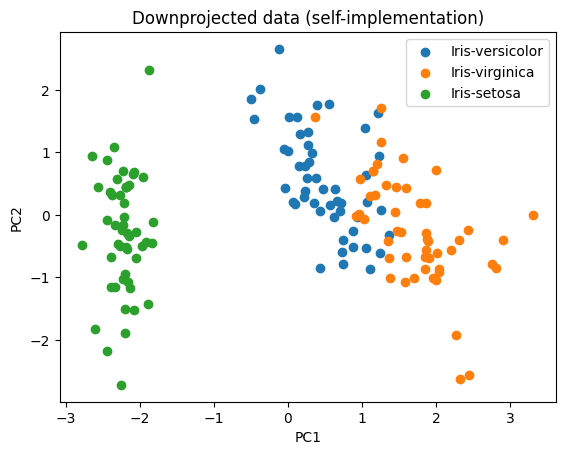

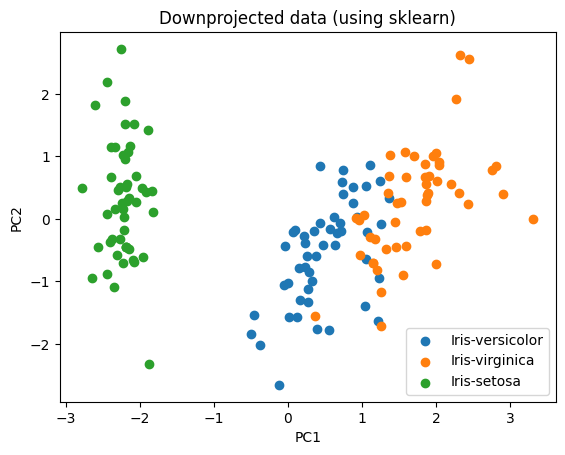

In [18]:
#nothing to do here
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values
classes = list(set(y))

colors = sns.color_palette(n_colors=len(classes)).as_hex()

for index,c in enumerate(classes):
        plt.scatter(Y[y==c,0], Y[y==c,1], color=colors[index], label=c)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Downprojected data (self-implementation)")
plt.legend()
plt.show()

for index,c in enumerate(classes):
        plt.scatter(Y_sklearn[y==c,0], Y_sklearn[y==c,1], color=colors[index], label=c)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Downprojected data (using sklearn)")
plt.legend()
plt.show()